# Data Preprocessing


- **Binning (Sum)**: All spectra are binned uniformly (sum) from range [100-1500] with step 0.02  
- **Normalization**: TIC



In [ ]:
from pyimzml.ImzMLParser import ImzMLParser
import numpy as np
import random
import matplotlib.pyplot as plt
import math


p = ImzMLParser('../Data/LPS/Control1.imzml')
my_spectra = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y, z)])

print(f"Total spectra loaded: {len(my_spectra)}")


In [51]:
max_mz = -float('inf')
min_mz = float('inf')
for spectrum in my_spectra:
    max_mz = math.ceil(max(max(spectrum[0]),max_mz))
    min_mz = math.floor(min(min(spectrum[0]),min_mz))
print(f'Range of mz values:',(min_mz,max_mz))




Range of mz values: (150, 2000)


In [53]:
common_mzs = np.arange(min_mz,max_mz,0.02)
binned = np.zeros((len(my_spectra), len(common_mzs)), dtype=np.float32)

for i, (mzs, intensities,_) in enumerate(my_spectra):
    indices = np.digitize(mzs, common_mzs) - 1
    for k, val in zip(indices, intensities):
        if 0 <= k < binned.shape[1]:
            binned[i, k] += val


tic = binned.sum(axis=1, keepdims=True)
X = binned / tic

# Convert to float16 AFTER normalization (values are now 0-1 range)
X = X.astype(np.float16)
print(f"Matrix created!")
print(f"Matrix has dimensions of",X.shape)


Matrix created!
Matrix has dimensions of (1636, 92500)


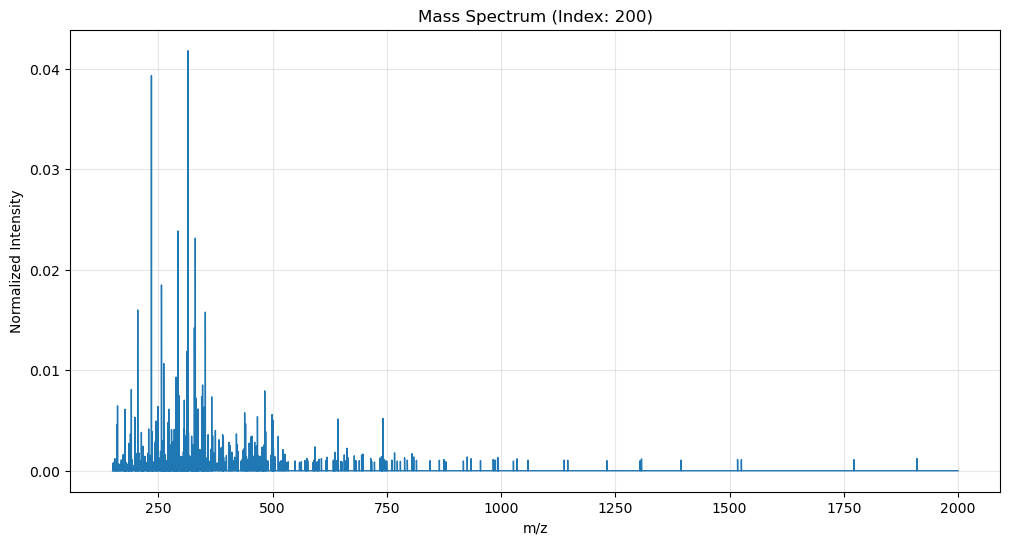

In [55]:

# Plot a random spectrum
spectrum_idx = 200
plt.figure(figsize=(12, 6))
plt.plot(common_mzs, X[spectrum_idx], linewidth=1.0)
plt.xlabel('m/z')
plt.ylabel('Normalized Intensity')
plt.title(f'Mass Spectrum (Index: {spectrum_idx})')
plt.grid(True, alpha=0.3)
plt.show()

In [56]:
# Save the processed data to npy files
np.save('../Data/LPS/control1_x.npy', X)
np.save('../Data/LPS/control1_mzs.npy', common_mzs)
np.save('../Data/LPS/control1_coords.npy', [coord for _, _, coord in my_spectra])

